Projet Covid 19 and Normal Lung 

Création et entraînement d'un modèle pour détérminer à travers des images radiographiques du poumon la

1°- import des librairies 

In [33]:
from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as Inception 
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.layers import Input, Conv2D, multiply,LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras import metrics
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
%matplotlib inline


2°- Normalisation, augmentation du nombre des images à partir des images du dataset, création d'un subset de 30% 
des images pour la validation.

In [34]:
data_generator=ImageDataGenerator(
rescale=1./255,
rotation_range=20,
zoom_range=0.2,
validation_split=0.3,
)


3°- A partir du dossier racine des images "datset" que contient les sous-répertoires (les 2 classes):
    radio Pumon COVID-19 et Pumon Normal
    Création des datasets distiné à l'entraînement et à la vadidation du modèle.

In [35]:
path="C:/Users/utilisateur/Desktop/projet_lung/dataset/"

train_generator = data_generator.flow_from_directory(path, shuffle=True, seed=13,target_size = (256,256),
                                                    class_mode='categorical', batch_size=50,
                                                    subset='training')

valid_generator = data_generator.flow_from_directory(path, shuffle=True, seed=13,target_size = (256,256),
                                                    class_mode='categorical', batch_size=50,
                                                    subset='validation')


Found 1771 images belonging to 2 classes.
Found 758 images belonging to 2 classes.


In [36]:
classes = list(train_generator.class_indices.keys())

In [38]:
classes

['COVID', 'NORMAL']

4° Création d'un modèle avec un réseau neural en utilisant du Transfer Learning que consiste à utiliser un réseau de neurone déjà entraîné avec des millions d'autres images destiné à la classification d'images ( inception et les poids Imagenet et include_top=False) 


In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

In [40]:
## ModelCheckpoint pour garder le modèle avec la plus haute accuracie pendant l'entrainement.

filepath='model_ray_x.hdf5'

checkpoint=ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
                                    mode='max', save_freq='epoch')
    



In [41]:
## intervient  intervient dans la descente de gradienton modifie le learning rate si on est sur un plateau pour essayer de sortir d'un minimum local par exemple

lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1 ,min_delta=1e-4,  patience=5,verbose=1)
                                   
    

In [42]:
callbacks=[checkpoint,lr_reducer]

In [43]:

base_modele_pre_entraine= Inception(input_shape=(256,256,3), 
                                include_top=False, weights='imagenet')

In [44]:
x = base_modele_pre_entraine.output

In [45]:
x=GlobalAveragePooling2D()(x)

In [46]:
x=BatchNormalization()(x)

In [47]:
dense_layers=Dense(512,activation ='relu',kernel_initializer = 'he_normal')(x)

In [48]:
dense_layers=Dropout(0.3)(dense_layers)

In [49]:
out_layer = Dense(2, activation = 'sigmoid')(dense_layers)

In [50]:
final_model=Model(inputs=[base_modele_pre_entraine.input],
                  outputs=[out_layer], name='final_model')

In [51]:
final_model.compile(optimizer= Adam (lr=1e-3), loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

In [52]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

history= final_model.fit_generator(train_generator,
                                   steps_per_epoch=STEP_SIZE_TRAIN,
                                   validation_data = valid_generator,
                                   validation_steps=STEP_SIZE_VALID,
                                   callbacks=callbacks,
                                   epochs = 30)

                         

Epoch 1/30
35/35 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9537 
Epoch 00001: val_accuracy improved from -inf to 0.47067, saving model to model_ray_x.hdf5
35/35 [==============================] - 1196s 34s/step - loss: 0.1588 - accuracy: 0.9537 - val_loss: 40278.7656 - val_accuracy: 0.4707
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9901 
Epoch 00002: val_accuracy improved from 0.47067 to 0.78667, saving model to model_ray_x.hdf5
35/35 [==============================] - 1202s 34s/step - loss: 0.0254 - accuracy: 0.9901 - val_loss: 747.0025 - val_accuracy: 0.7867
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9930 
Epoch 00003: val_accuracy improved from 0.78667 to 0.98400, saving model to model_ray_x.hdf5
35/35 [==============================] - 1176s 34s/step - loss: 0.0169 - accuracy: 0.9930 - val_loss: 75.2280 - val_accuracy: 0.9840
Epoch 4/30
35/35 [==================

KeyboardInterrupt: 

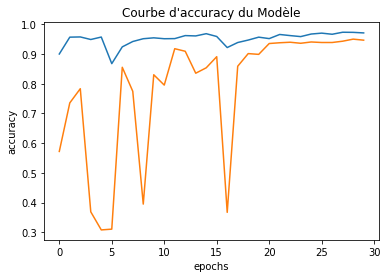

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Courbe d'accuracy du Modèle")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()
plt.show()

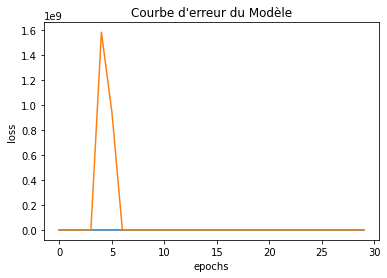

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Courbe d'erreur du Modèle")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

5° Enregistre le modèle pour être utiliser dans la machine de triage de déchêts

In [55]:
final_model.save('model_ray_x.hdf5')

In [77]:
lista_clas_rep_test=["COVID","COVID","COVID","COVID","COVID","COVID","COVID","NORMAL","NORMAL","NORMAL", 
                     "NORMAL","NORMAL","NORMAL","NORMAL"]

6° Prédictions concernant le tri des déchêts des images dans le répertoire camera. Resultats : Prédiction + image

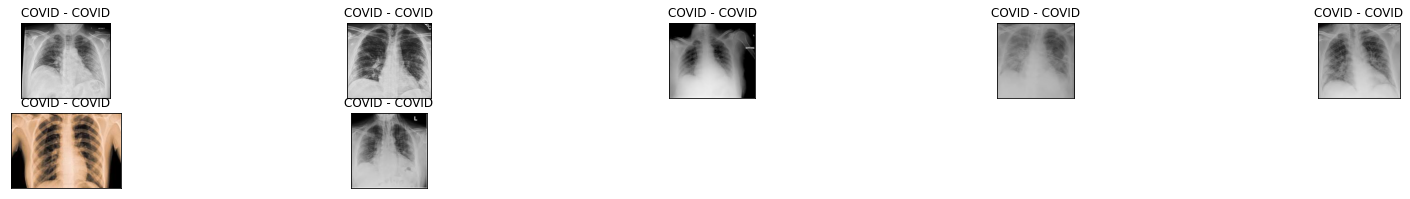

In [89]:
##path="nouvelles_images/*.jpg"
path="C:/Users/utilisateur/Desktop/projet_lung/images_internet/*"
images=glob.glob(path)
listay=[]
listaclas=[]

plt.figure(figsize=(28,13))
i=0
k=0
for imagem in images:
    reader = cv2.imread(imagem)
    img = image.load_img(imagem, target_size = (256,256), color_mode='rgb')
    x = (image.img_to_array(img))/255
    x = np.expand_dims(x, axis=0)
    y = final_model.predict(x)
    listay.append(y[0][np.argmax(y)])
    listaclas.append(classes[np.argmax(y)])
    plt.subplot(8,5,i+1),plt.imshow(reader,'gray')
    i=i+1
    plt.title(classes[np.argmax(y)]+" - "+lista_clas_rep_test[k])
    k=k+1
    plt.xticks([]),plt.yticks([])

In [57]:
path="C:/Users/utilisateur/Desktop/projet_lung/images_patiens/*png"
images=glob.glob(path)




for imagem in images:
    
    print(imagem[56:])

COVID (1).png
COVID (1195).png
COVID (1196).png
COVID (1198).png
COVID (1199).png
COVID (1200).png
COVID (63).png
NORMAL (1335).png
NORMAL (1336).png
NORMAL (1337).png
NORMAL (1338).png
NORMAL (1339).png
NORMAL (1340).png
NORMAL (1341).png


7° Liste de images en ordre de lecture du repertoire camera.

In [78]:

y_true = np.array(lista_clas_rep_test)
y_pred =np.array(listaclas)

In [79]:
y_pred
y_true

array(['COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID', 'COVID',
       'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL',
       'NORMAL'], dtype='<U6')

8° Evaluation du Modèle

In [80]:
print(classification_report(y_true,y_pred, target_names = ["COVID","NORMAL"]))

              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00         7
      NORMAL       1.00      1.00      1.00         7

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



In [81]:
confusion_matrix(y_true, y_pred)

array([[7, 0],
       [0, 7]], dtype=int64)

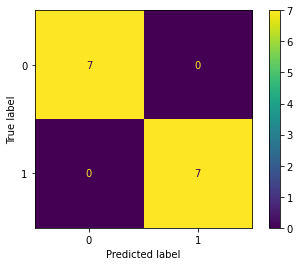

In [82]:
cm = confusion_matrix(y_true, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

Le modèle s'est trompe sur les couverts([2,5]) : il prédit gobelets_sales à la place de couverts


In [84]:
#calcul de  la somme des éléments de la dyagonale de la matrice de confusion
dyag=0
for i in range(2):
    dyag=cm[i,i]+dyag


In [85]:
# somme totale des éléments de la matrice de confusion
total=sum(sum(cm))

In [86]:
#calcul accuracy

acc = (dyag/total)
print(f'Accuracy =',acc)

Accuracy = 1.0
